In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
from warnings import simplefilter,filterwarnings
from sklearn.exceptions import DataConversionWarning
simplefilter(action='ignore',category = FutureWarning)
simplefilter(action='ignore',category = RuntimeWarning)
filterwarnings(action='ignore',category=DataConversionWarning)

## 0.0.1 Import Data

In [3]:
raw_data = pd.read_csv("corn_data.csv")
raw_data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1126,1127,1128,1129,1130,1131,1132,1133,1134,output
0,0,1,-1,1,1,1,0,1,-1,1,...,-1,1,-1,1,1,-1,0,0,-1,2.516485
1,1,1,-1,1,1,-1,-1,1,-1,1,...,-1,1,-1,0,1,-1,-1,1,0,1.640909
2,2,0,1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,1,1,-1,-1,1,0,0.416348
3,3,1,1,1,0,-1,1,1,-1,1,...,-1,1,-1,-1,1,-1,-1,1,0,1.338558
4,4,1,1,1,0,-1,-1,1,0,1,...,-1,1,-1,0,-1,-1,1,1,0,1.729517


In [4]:
X = raw_data.iloc[:,1:-1]
y = raw_data.iloc[:,-1:]
print("X shape:",X.shape)
print("y shape:",y.shape)
print("Min y:",min(np.array(y))[0])
print("Max y:",max(np.array(y))[0])

X shape: (264, 1135)
y shape: (264, 1)
Min y: 0.0117532464005208
Max y: 4.9270454514617015


## 0.0.2 Visualize our data

We would like to visualize how the values of the output are distributed, using a histogram. 

Since our output values range from 0.01 to 4.92, it makes sense to display our output in bins from [0-1] to [4-5]

Text(0.5, 1.0, 'Output Distribution')

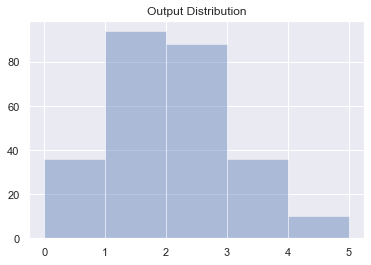

In [5]:
sns.distplot(y,bins=[0,1,2,3,4,5],kde=False)
plt.title("Output Distribution")


Remark: Most of our values falls within [1-3]. The highest yields [4-5], unsurprisingly, are the fewest

## 0.0.3 Construct a Scoring system

### i- Scorer class
First construct a scoring class. This will keep track of all our scores.

In [44]:
class ScoreSheet:
    def __init__(self,title):
        self.title=title
        self.sheet = pd.DataFrame({})
        
    def add_score(self,name,list):
        self.sheet.loc[name]=list
        
    def add_score(self,series):
        self.sheet = self.sheet.append(series)
        
    def get_pred_labels(self):
        return list(self.sheet.columns)
    
    def get_test_labels(self):
        return list(self.sheet.index)
    
    def get_test(self,name):
        return self.sheet.loc[name]
    
    def get_predictor(self,name):
        return list(self.sheet[name])
    
    def get_sheet(self):
        return self.sheet
    
    

### ii - Draw class

This class will help with the plotting of graphs in the ScoreSheet and Test

- v1.0

In [59]:
class Draw:
    
    def histogram(sr,hist,kde):
        sns.distplot(sr,bins=[0,1,2,3,4,5],hist=hist,kde=kde)
    
    def heatmap(ss):
        ax=sns.heatmap(ss.get_sheet(),annot=True, fmt=".3f",cmap="coolwarm", center = -0.1 ,
                       square = True,linewidths=.1,vmin=-1,vmax=1,cbar=False)
        plt.title(ss.title)
        plt.show()
    
    def lineplot(ss,cols):
        ax = plt.subplot()
        for name in cols:
            x = ss.get_test_labels()
            y = ss.get_predictor(name)
            plt.plot(x,y)
            ax.set_ylim([0.0,1.0])
        ax.legend()
        plt.show()
    
    def scatterplot(train_series,test_series):
#         plt.subplot()
        plt.xlabel("Actual values")
        plt.ylabel("Predicted values")
        y_train,y_train_predicted = train_series["y_train"],train_series["y_train_predicted"]
        y_test, y_test_predicted  = test_series["y_test"], test_series["y_test_predicted"]
        plt.plot(y_train, y_train_predicted, 'x', color='red')
        plt.plot(y_test,y_test_predicted, 'o', color='black')
        plt.plot(np.linspace(0,5,10),np.linspace(0,5,10),'b--')
        plt.show()

### iii - Test class

In [14]:
from random import random
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split  


class Test:
    def __init__(self,X,y):
        self.settings = Settings(X,y)
        
    def get_settings(self):
        return self.settings
    
    def set_settings(self,settings):
        self.settings = settings
  
    # Split the data and fit the classifier. Will split according to stratify, bias
    def split(self):
        sttg = self.get_settings()
        if sttg.bias > 0:
            X_train, X_test, y_train, y_test = sttg.biased_split()
        else:
            X_train, X_test, y_train, y_test = train_test_split(sttg.X,sttg.y,test_size=sttg.split,stratify=sttg.strf)
        return X_train, X_test, y_train, y_test
    
    # Determine the R2 Score for a list of predictors
    def R2(self,predictors):
        train_r2 = []
        test_r2 = []
        for clf_name in predictors:
            sttg = self.get_settings()
            clf = sttg.predictor(clf_name)
            X_train, X_test, y_train, y_test = self.split()
            clf.fit(X_train,y_train)
            y_train_predicted = clf.predict(X_train)
            y_test_predicted  = clf.predict(X_test)            
            train_r2.append(r2_score(y_train,y_train_predicted))
            test_r2.append(r2_score(y_test,y_test_predicted))
        return pd.Series(train_r2,index=predictors,name="Train R2"),pd.Series(test_r2,index=predictors,name="Test R2")
    
    def R2_avg(self,predictors,iterations):
        all_train_r2 = []
        all_test_r2 = []
        for i in range(iterations):
            train_r2,test_r2 = self.R2(predictors)
            all_train_r2.append(list(train_r2))
            all_test_r2.append(list(test_r2))
        mean_train_r2 = [np.mean(i) for i in np.array(all_train_r2).T]
        mean_test_r2 = [np.mean(i) for i in np.array(all_test_r2).T]
        return pd.Series(mean_train_r2,index=predictors,name="Train R2"),pd.Series(mean_test_r2,index=predictors,name="Test R2")
    
    

### iv - Settings class

Keep track of all the settings and predictors including split_size, stratification option, grid search, etc...

In [15]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor

class Settings:
    def __init__(self,X,y):
        self.X = X
        self.y = y
        self.strf = None
        self.split = 0.2
        self.bias = 0
        self.bias_threshold = 3
        
    def predictor(self,clf_name):
        pred = {"SVR":SVR(),'RFR':RandomForestRegressor(),
               "XGB":XGBRegressor(),"ADA":AdaBoostRegressor()}
        return pred[clf_name]
    
    def get_stratify(self):
        return self.strf
    
    def set_stratify(self,bool):
        if bool:
            self.strf = np.array(self.y,dtype="int")
        else:
            self.strf = None
            
    def get_y_stratified(self,y):
        return np.array(y,dtype="int")
    
    def set(self,strf,split,bias,bias_threshold):
        self.strf = strf
        self.split = split
        self.bias = bias
        self.bias_threshold = bias_threshold
        return self.strf,self.split,self.bias,self.bias_threshold

    
    def set_default(self):
        self.strf = None
        self.split = 0.2
        self.bias = 0
        self.bias_threshold = 3
        return self.strf,self.split,self.bias,self.bias_threshold
    
    def set_split(self,split):
        self.split = split
        
    def get_split(self):
        return self.split
    
    def set_bias(self,bias,threshold):
        self.bias = bias
        self.bias_threshold = threshold
            
    def biased_split(self):
        filt1 = raw_data["output"] >= self.bias_threshold #Filter out outputs that are higher than threshold
        filt2 = raw_data["output"] < self.bias_threshold
        df1 = raw_data[filt1]
        df2 = raw_data[filt2]

        X_021a = df1.iloc[:,1:-1]
        y_021a = df1.iloc[:,-1:]
        X_021b = df2.iloc[:,1:-1]
        y_021b = df2.iloc[:,-1:]

        X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_021a,y_021a,test_size=self.bias,
                                                        stratify=np.array(y_021a,dtype="int"))
        X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_021b,y_021b,test_size=self.split,
                                                        stratify=np.array(y_021b,dtype="int"))

        y_train = y_train_a.append(y_train_b)
        X_train = X_train_a.append(X_train_b)
        y_test = y_test_a.append(y_test_b)
        X_test = X_test_a.append(X_test_b)

        return X_train, X_test, y_train, y_test
    
    def print_settings(self):
        print(self.split,
            self.bias,
            self.bias_threshold)

### v - Useful Functions

In [60]:
test = Test(X,y)

## 0.1.0 Raw R2 Score

In [61]:
test.settings.set_default()
train_sr,test_sr = test.R2(["ADA","RFR","SVR","XGB"])

In [62]:
ss = ScoreSheet("Raw R2 Score")
ss.add_score(train_sr)
ss.add_score(test_sr)
print(ss.title)
ss.get_sheet().head()

Raw R2 Score


,ADA,RFR,SVR,XGB
Train R2,0.762646,0.843319,0.743797,1.000000
Test R2,0.021745,0.076716,0.108111,0.122583


In [63]:
train_avg,test_avg = test.R2_avg(["ADA","RFR","SVR","XGB"],iterations=5)

ss = ScoreSheet("Average Raw R2")
ss.add_score(train_avg)
ss.add_score(test_avg)
print(ss.title)
ss.get_sheet().head()

Average Raw R2


,ADA,RFR,SVR,XGB
Train R2,0.751289,0.846893,0.732358,1.000000
Test R2,0.115626,-0.027334,0.153570,-0.057836


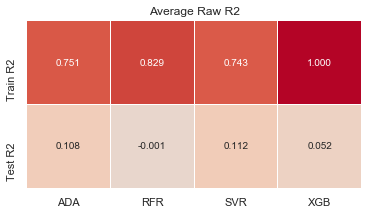

In [53]:
Draw.heatmap(ss)

## 0.2.0 Stratify our Data

What does stratification do to our data?

In [64]:
data = {"Original data":raw_data["output"],"Stratified data":list(np.array(test.settings.y,dtype='int').ravel())}
df1 = pd.DataFrame(data = data)
df1.head(10)

,Original data,Stratified data
0,2.516485,2
1,1.640909,1
2,0.416348,0
3,1.338558,1
4,1.729517,1
5,2.704476,2
6,1.971622,1
7,1.843582,1
8,2.082107,2
9,2.898305,2


We are creating bins for our data. In a way, we are turning the problem from regression into classification. 

This way we can use tools that are only available to classification to enhance our model

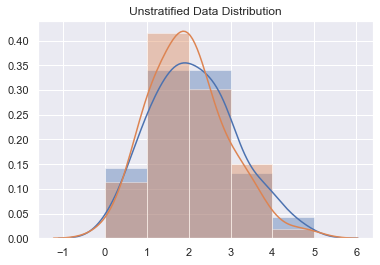

In [65]:
test.settings.set_default()
X_train, X_test, y_train, y_test = test.split()
plt.title("Unstratified Data Distribution")
Draw.histogram(y_train,hist=True,kde=True)
Draw.histogram(y_test,hist=True,kde=True)

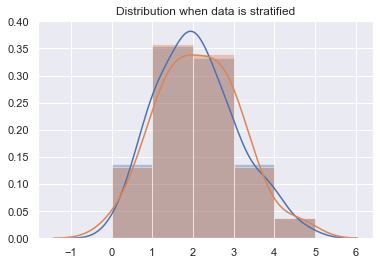

In [70]:
test.settings.set_default()
test.settings.set_stratify(True)
X_train, X_test, y_train, y_test = test.split()

plt.title("Distribution when data is stratified")
Draw.histogram(y_train,hist=True,kde=True)
Draw.histogram(y_test,hist=True,kde=True)

The distribution plots for train data and test data now sit on top of each other perfectly. 
This means the relative proportion of each bin to the total population (in both test data and train data) are maintained during the split.

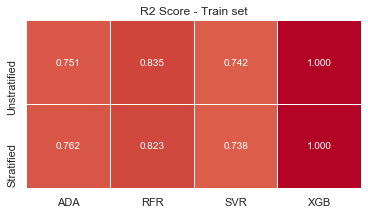

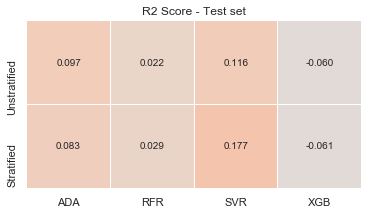

In [74]:
ss_trn = ScoreSheet("R2 Score - Train set")
ss_tst = ScoreSheet("R2 Score - Test set")

test.settings.set_default()
train_avg,test_avg = test.R2_avg(["SVR","ADA","RFR","XGB"],iterations=10)
train_avg.name = 'Unstratified'
test_avg.name = 'Unstratified'
ss_trn.add_score(train_avg)
ss_tst.add_score(test_avg)

test.settings.set_stratify(True)
train_avg,test_avg = test.R2_avg(["SVR","ADA","RFR","XGB"],iterations=10)
train_avg.name = 'Stratified'
test_avg.name = 'Stratified'
ss_trn.add_score(train_avg)
ss_tst.add_score(test_avg)

Draw.heatmap(ss_trn)
Draw.heatmap(ss_tst)

Stratification seems promising! ADA and SVR performed significantly better. The method might have helped with solving the issue of class imbalance while training the data

Still we want to do better. Let's make bins [3-4] and [4-5] more significant in the training process by introducing bias

## 0.2.1 Biased Split
Let's look to manually increase bias towards higher yield

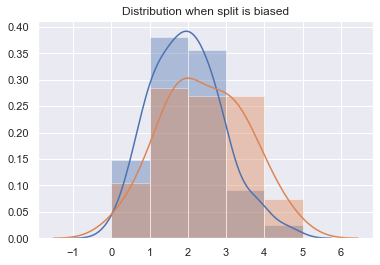

In [75]:
test.settings.set_bias(bias=0.5,threshold=3) 
#This means for outputs larger than threshold, the split is 0.5 instead of default split 0.2

X_train, X_test, y_train, y_test = test.split()
plt.title("Distribution when split is biased")
Draw.histogram(y_train,hist=True,kde=True)
Draw.histogram(y_test,hist=True,kde=True)

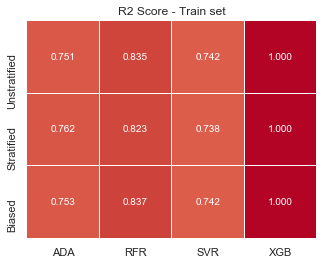

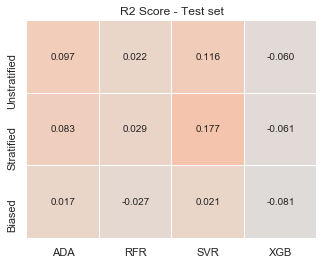

In [76]:
test.settings.set_default()
test.settings.set_bias(bias=0.5,threshold=3) 

train_avg,test_avg = test.R2_avg(["SVR","ADA","RFR","XGB"],iterations=10)
train_avg.name = 'Biased'
test_avg.name = 'Biased'
ss_trn.add_score(train_avg)
ss_tst.add_score(test_avg)

Draw.heatmap(ss_trn)
Draw.heatmap(ss_tst)

Unfortunately doing so doesn't seem to help with the R2 score in general as all models perform worse.

Let's see the actual performance of a test